In [10]:
import os
from decimal import Decimal
import numpy as np
from numpy import genfromtxt
import glob
import re
import importlib
import gc
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import scale
import pandas as pd
import keras
from keras.models import load_model
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers import Input, Concatenate
from keras.callbacks import ModelCheckpoint
from platform import python_version
import tensorflow as tf

rmse = tf.keras.metrics.RootMeanSquaredError()

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__)

Notebook running on Python 3.8.12
Numpy version 1.21.4
Keras version  2.7.0 and TensorFlow 2.7.0


In [7]:
ds=[]
orden=[]
total_samples = 0
for filename in glob.glob("Dataset/NNTrainingTesting-3p-3c-v7_*.csv"):
    temp=filename[41:-1].split("_")
    DP=temp[:1]
    DP=''.join(DP)
    DP=int(DP)
    orden.append(DP)
    if DP >= 100:
        params = np.array(filename[47+2:-4].split("_"), dtype=np.float32)#loading the parameters from the .csv file name
    elif DP >= 10:
        params = np.array(filename[47+1:-4].split("_"), dtype=np.float32)
    else:
        params = np.array(filename[47:-4].split("_"), dtype=np.float32)  
    data = genfromtxt(filename, delimiter='\n')
    row = np.concatenate((data, params), axis=0)#joining the velocity data (features) and the parameters (labels)
    ds.append(row)
    total_samples+=1
print("Total samples: ", total_samples)

ds = np.array(ds, dtype=np.float32)
orden=np.array(orden, dtype=np.int32)


print(ds.shape)

Total samples:  500
(500, 603)


# Training and Testing Data preparation

In [8]:
features=np.array(ds[:,:600])#separating features and labels
labels=np.array(ds[:,600:])/5000#converting all labels to be between 0 and 1 for Mz and between -1 and 1 for Mr and Mt

scaler=StandardScaler()
scaler.fit(features)

train_final_input = features[:400,:]
test_final_input = features[400:,:]
train_final_label=labels[:400,:]
test_final_label=labels[400:,:]

train_final_input=scaler.transform(train_final_input)
test_final_input=scaler.transform(test_final_input)

trainfi_Vx=np.array(train_final_input[:,0:598:3])
trainfi_Vy=np.array(train_final_input[:,1:599:3])
trainfi_Vz=np.array(train_final_input[:,2:600:3])

testfi_Vx=np.array(test_final_input[:,0:598:3])
testfi_Vy=np.array(test_final_input[:,1:599:3])
testfi_Vz=np.array(test_final_input[:,2:600:3])

trainfi_Vx_pd=pd.DataFrame(trainfi_Vx)
trainfi_Vy_pd=pd.DataFrame(trainfi_Vy)
trainfi_Vz_pd=pd.DataFrame(trainfi_Vz)
testfi_Vx_pd=pd.DataFrame(testfi_Vx)
testfi_Vy_pd=pd.DataFrame(testfi_Vy)
testfi_Vz_pd=pd.DataFrame(testfi_Vz)


trainfl_pd=pd.DataFrame(train_final_label)
testfl_pd=pd.DataFrame(test_final_label)

print(trainfi_Vx_pd.shape)
print(testfi_Vx_pd.shape)
print(trainfl_pd.shape)
print(testfl_pd.shape)

(400, 200)
(100, 200)
(400, 3)
(100, 3)


In [12]:
leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.2)

# Neural Network Architecture 

In [6]:
lr=1e-5
vldsplt=0.2
NumberOFBatches=15
bz=int(len(train_final_input)*(1-vldsplt)/NumberOFBatches)
print(bz)
rglz=0.02

21


In [13]:
I1=Input(shape=(200,))
I2=Input(shape=(200,))
I3=Input(shape=(200,))

h1_p1=Dense(200,activation=leakyrelu)(I1)
h1_p2=Dense(200,activation=leakyrelu)(I2)
h1_p3=Dense(200,activation=leakyrelu)(I3)
h1=Concatenate()([h1_p1,h1_p2,h1_p3])
h2=Dense(500,activation=leakyrelu)(h1)
hdp1=keras.layers.Dropout(0.5)(h2)
h3=Dense(420,activation=leakyrelu)(hdp1)
hdp2=keras.layers.Dropout(0.35)(h3)
h4=Dense(360,activation=leakyrelu)(hdp2)
hdp3=keras.layers.Dropout(0.25)(h4)
h5=Dense(300,activation=leakyrelu)(hdp3)
hdp4=keras.layers.Dropout(0.15)(h5)
h6=Dense(150,activation=leakyrelu)(hdp4)
h7=Dense(75,activation=leakyrelu)(h6)
h8=Dense(32,activation=leakyrelu)(h7)
Out=Dense(3)(h8)

model=keras.models.Model(inputs=[I1,I2,I3],outputs=Out)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=[rmse, 'mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          40200       ['input_4[0][0]']                
                                                                                              

# Training

In [14]:
history = model.fit(
    [trainfi_Vx_pd,trainfi_Vy_pd,trainfi_Vz_pd], trainfl_pd,
    epochs=15000,
    verbose=0,
    validation_split = vldsplt)

# Evaluation 

In [15]:
def plot_loss(history,maximo):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, maximo])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

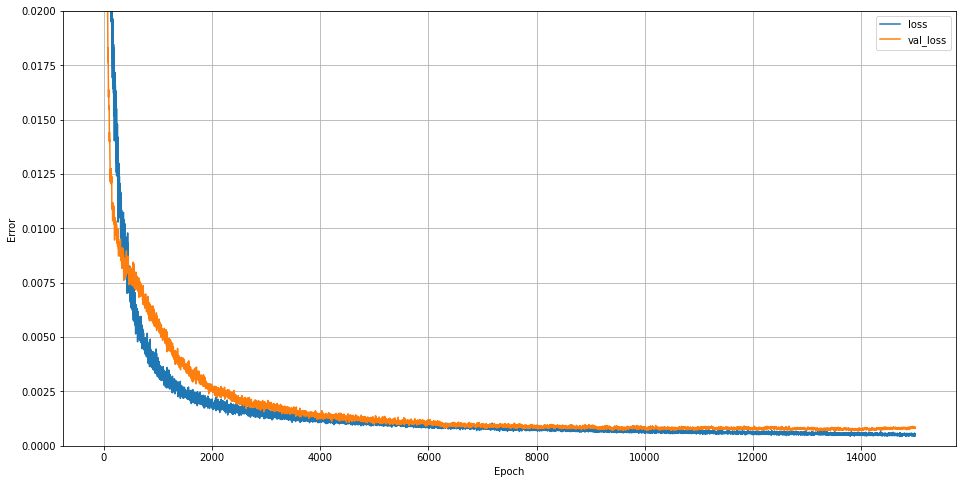

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_loss(history,0.02)

In [17]:
results= model.evaluate([testfi_Vx_pd,testfi_Vy_pd,testfi_Vz_pd], testfl_pd, verbose=1)

4/4 [==============================] - 0s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - mae: 0.0192


# Saved of the NN and the predictions

In [12]:
model.save("NN_for_MomentumSources.h5")

In [15]:
predictions=model.predict([testfi_Vx_pd,testfi_Vy_pd,testfi_Vz_pd], verbose=1)
finalPredictions=predictions*5000

4/4 [==============================] - 0s 6ms/step


In [25]:
np.savetxt('Predictions_momentumSources.csv', finalpredictions, delimiter=';', fmt='%0.6f')